<h1>LSTM</h1>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

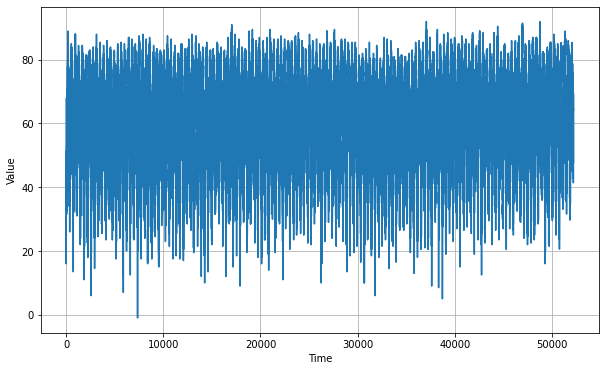

In [4]:
import csv
time_step = []
temps = []

with open('Birmingham-mean.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 40000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [20]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.LSTM(64), 
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(40000,)
Epoch 1/100
156/156 [==============================] - 20s 109ms/step - loss: 2534.5552 - mae: 47.7507
Epoch 2/100
156/156 [==============================] - 17s 107ms/step - loss: 1562.1978 - mae: 36.5217
Epoch 3/100
156/156 [==============================] - 19s 120ms/step - loss: 1023.6035 - mae: 28.5335
Epoch 4/100
156/156 [==============================] - 19s 123ms/step - loss: 676.5035 - mae: 22.4341
Epoch 5/100
156/156 [==============================] - 18s 116ms/step - loss: 464.1018 - mae: 18.3101
Epoch 6/100
156/156 [==============================] - 18s 112ms/step - loss: 342.8297 - mae: 15.7969
Epoch 7/100
156/156 [==============================] - 18s 118ms/step - loss: 279.0479 - mae: 14.3747
Epoch 8/100
156/156 [==============================] - 18s 114ms/step - loss: 248.4943 - mae: 13.6172
Epoch 9/100
156/156 [==============================] - 19s 118ms/step - loss: 

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [22]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

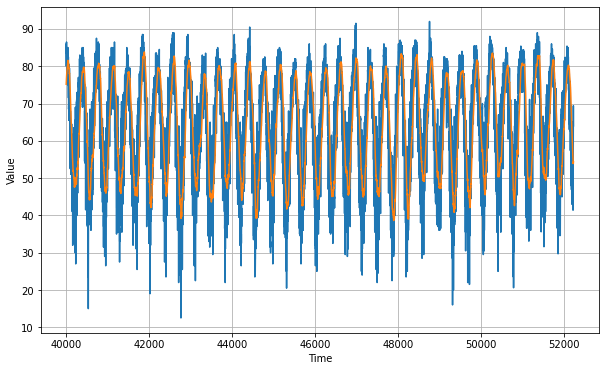

In [24]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.7593384

In [26]:
#mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy().mean()
#print(mae)

In [27]:
model.save('LSTM_model.h5')

In [28]:
model = tf.keras.models.load_model('LSTM_model.h5')